In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, auc

%matplotlib inline

In [1058]:
trainDf = pd.read_csv("./train_data.csv", encoding="utf-8")
testDf = pd.read_csv("./test_features.csv", encoding="utf-8")

idxOfTrain = trainDf.shape[0]
target = trainDf["poi"].map({True:1, False:0})
trainName = trainDf["name"]
trainDf = trainDf.drop(["poi"],axis=1)
df = pd.concat([trainDf, testDf])
testName = df[idxOfTrain:]["name"]
print(f'''
看一下總共幾筆訓練集: {idxOfTrain}
看一下訓練+測試共幾筆:{df.shape[0]}
''')



看一下總共幾筆訓練集: 113
看一下訓練+測試共幾筆:146



In [1059]:

def featureFilter(data, typeString):
    
    if not isinstance(trainDf, pd.DataFrame):
        raise TypeError("Type of data must be DataFrame.")
    
    typeStringBox = ["float64", "object"]
    if not typeString in typeStringBox:
        raise ValueError("typeString must be float64 or object.")    
    feature_number = []
    for t, col in zip(data.dtypes, data.columns):
        if t == typeString:
            feature_number.append(col)

    return feature_number

feature_number = featureFilter(df, "float64")
print("看一下數值型特徵:\n", feature_number)

看一下數值型特徵:
 ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']


In [1060]:
def featureNullRatio(data, ascending=False):

    if not isinstance(data, pd.DataFrame):
        raise TypeError("Type of data must be pd.DataFrame.")
    
    if not isinstance(ascending, bool):
        raise TypeError("Type of ascending must be bool.")

    ratio = data.isnull().sum() / data.shape[0]
    
    return ratio.sort_values(ascending=ascending)

ratio = featureNullRatio(df)
print("缺失值占全體數據的比例:\n", ratio)

缺失值占全體數據的比例:
 loan_advances                0.972603
director_fees                0.883562
restricted_stock_deferred    0.876712
deferral_payments            0.732877
deferred_income              0.664384
long_term_incentive          0.547945
bonus                        0.438356
shared_receipt_with_poi      0.410959
from_poi_to_this_person      0.410959
from_messages                0.410959
to_messages                  0.410959
from_this_person_to_poi      0.410959
other                        0.363014
salary                       0.349315
expenses                     0.349315
exercised_stock_options      0.301370
restricted_stock             0.246575
email_address                0.239726
total_payments               0.143836
total_stock_value            0.136986
name                         0.000000
dtype: float64


========bonus========
count    8.200000e+01
mean     2.374235e+06
std      1.071333e+07
min      7.000000e+04
25%      4.312500e+05
50%      7.693750e+05
75%      1.200000e+06
max      9.734362e+07
Name: bonus, dtype: float64
========deferral_payments========
count    3.900000e+01
mean     1.642674e+06
std      5.161930e+06
min     -1.025000e+05
25%      8.157300e+04
50%      2.274490e+05
75%      1.002672e+06
max      3.208340e+07
Name: deferral_payments, dtype: float64
========deferred_income========
count    4.900000e+01
mean    -1.140475e+06
std      4.025406e+06
min     -2.799289e+07
25%     -6.948620e+05
50%     -1.597920e+05
75%     -3.834600e+04
max     -8.330000e+02
Name: deferred_income, dtype: float64
========director_fees========
count    1.700000e+01
mean     1.668049e+05
std      3.198914e+05
min      3.285000e+03
25%      9.878400e+04
50%      1.085790e+05
75%      1.137840e+05
max      1.398517e+06
Name: director_fees, dtype: float64
========exercised_stock_options=====

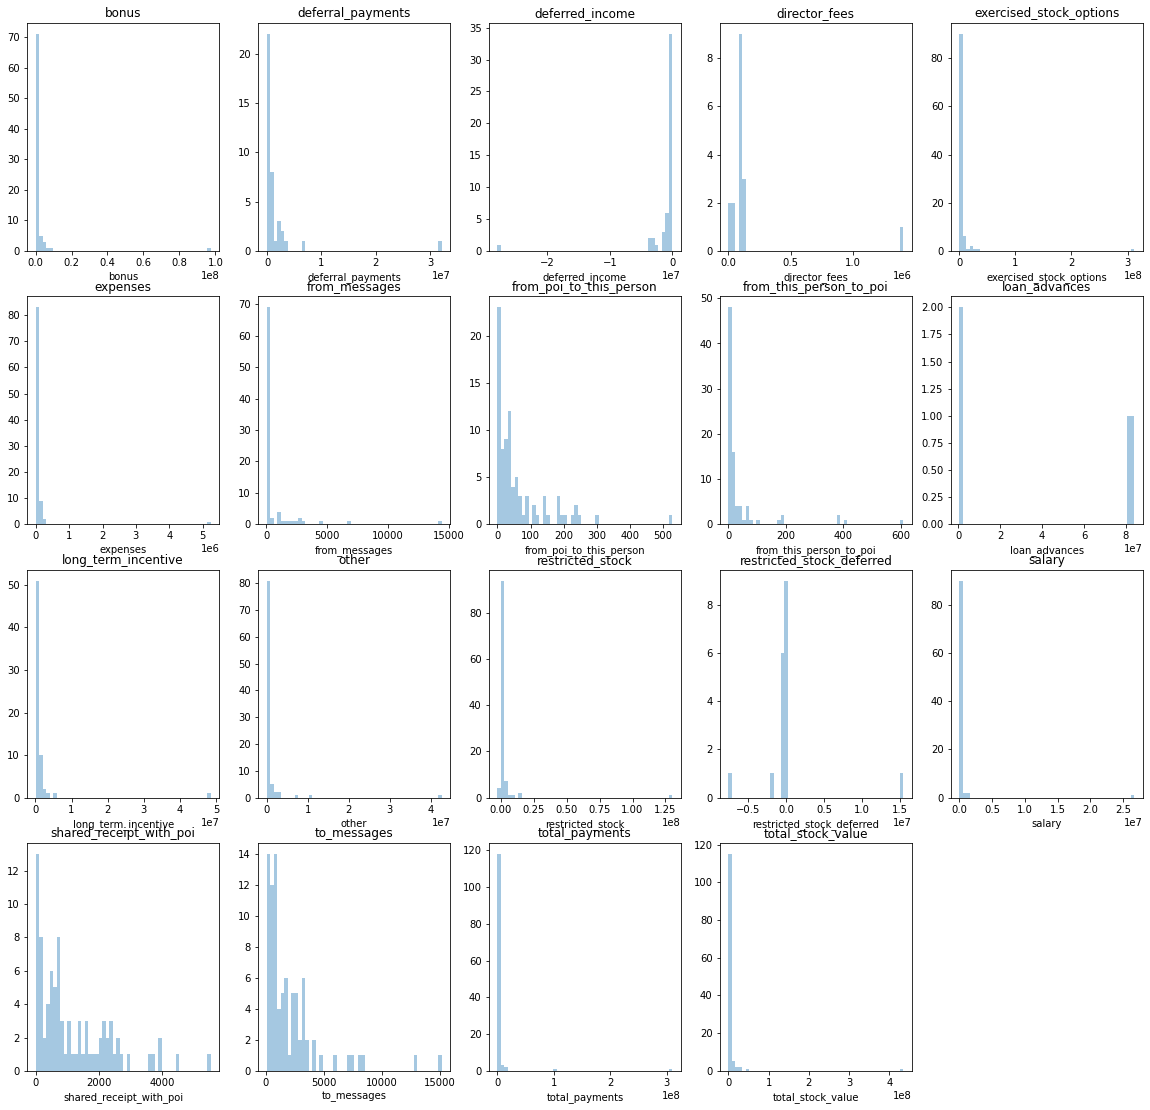

In [1061]:
def eda(data, target=None, figsize=(20,150), ncol=5, describe=True):

    if not isinstance(data, pd.DataFrame):
        raise TypeError("Type of data must be pd.DataFrame.")
    
    if target != None:
        if not isinstance(target, pd.Series):
            raise TypeError("Type of data must be pd.Series.")
    
    if not isinstance(figsize, tuple):
        raise TypeError("Type of figsize must be tuple.")

    if not isinstance(ncol, int):
        raise TypeError("Type of ncol must be int.")
    
    if not isinstance(describe, bool):
        raise TypeError("Type of describe must be bool.")

    plt.figure(figsize=figsize)

    Sum = data.shape[0]
    ncol = ncol
    nrow = (Sum // ncol) + 1
    for idx, colName in enumerate(data): 
        if describe == True:
            print(f"========{colName}========")
            print(data[colName].describe())
        plt.subplot(nrow, ncol, idx+1)
        data[colName].describe()
        plt.title(colName)
        sns.distplot(data[colName], bins=50, kde=False)

        if target != None:
            sns.regplot(data[colName], target, line_kws={"color":"orange"}, scatter_kws={"color":"black"})

    return

eda(df[feature_number])

In [1062]:
# translation_Array = ["deferral_payments",
#                      "deferred_income",
#                      "restricted_stock",
#                      "restricted_stock_deferred",
#                      "total_stock_value"]

# def feature_translate_to_N(data ,trainslation_Array):

#     if not isinstance(data, pd.DataFrame):
#         raise TypeError("Type of data must be pd.DataFrame.")

#     if not isinstance(trainslation_Array, list):
#         raise TypeError("Type of trainslation_Array must be list.")

#     for feature in translation_Array:
#         data[feature] = data[feature] + abs(data[feature].min())

#     return data

# df = feature_translate_to_N(df, translation_Array)

In [1063]:
def feature_fix(data, feature_fixArray, statistic="50%"):
    
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Type of data must be pd.DataFrame.")

    if not isinstance(feature_fixArray, list):
        raise TypeError("Type of feature_fixArray must be list.")
        
    for col in feature_fixArray:
        median = data[col].describe()[statistic]
        data[col] = data[col].fillna(median)
        # data[col] = np.log10(data[col])

    return data

feature_fixArray = feature_number
df = feature_fix(df, feature_fixArray)


In [1064]:

dropArray = ["total_payments","total_stock_value"]

dfAfterDrop = df.drop(["name", "email_address"], axis=1)

dfAfterDrop_copy = copy.copy(dfAfterDrop)
dfAfterDrop_copy = dfAfterDrop_copy.drop(dropArray, axis=1)

MMS = MinMaxScaler()
dfAfterMMS = MMS.fit_transform(dfAfterDrop_copy)
dfAfterlog1p = np.log1p(dfAfterMMS)

In [1065]:
train = dfAfterlog1p[:idxOfTrain]
test = dfAfterlog1p[idxOfTrain:]

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=47)

params = {
    "n_estimators":range(10,200,5),
    "max_depth":range(1,30),
    # "max_leaf_nodes":range(3,50)
}

CV, SCORING, VERBOSE, N_JOBS = 10, None, 1, 4

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, params, cv=CV, scoring=SCORING, verbose=VERBOSE, n_jobs=N_JOBS)
gridResult = grid.fit(x_train, y_train)
print("看一下隨機森林加上貪婪搜索的最佳分數: ", gridResult.best_score_)
print("隨機森林加上貪婪搜索最佳分數的參數組合為: ", gridResult.best_params_)

Fitting 10 folds for each of 1102 candidates, totalling 11020 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 760 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 1596 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 3036 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 4885 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 6964 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 9516 tasks      | elapsed:  4.4min
看一下隨機森林加上貪婪搜索的最佳分數:  0.9333333333333333
隨機森林加上貪婪搜索最佳分數的參數組合為:  {'max_depth': 2, 'n_estimators': 15}
[Parallel(n_jobs=4)]: Done 11020 out of 11020 | elapsed:  5.1min finished


In [1098]:
rfc = RandomForestClassifier(max_depth=2, n_estimators=15)
rfc.fit(x_train, y_train)
pred = rfc.predict(x_test)

acc = accuracy_score(y_test, pred)
print("使用隨機森林後的準確度: ", acc)
print("正確:", list(y_test))
print("預測:", list(pred))

使用隨機森林後的準確度:  0.782608695652174
正確: [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
預測: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [1099]:
params = {
    # "n_estimators":range(10,200,5),
    "max_depth":range(1,30),
    # "max_leaf_nodes":range(3,50)
}

grid = GridSearchCV(dtc, params, cv=CV, n_jobs=N_JOBS, scoring=SCORING)
gridResult = grid.fit(x_train, y_train)
print("看一下隨機森林加上貪婪搜索的最佳分數: ", gridResult.best_score_)
print("隨機森林加上貪婪搜索最佳分數的參數組合為: ", gridResult.best_params_)

看一下隨機森林加上貪婪搜索的最佳分數:  0.888888888888889
隨機森林加上貪婪搜索最佳分數的參數組合為:  {'max_depth': 1}


In [1118]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
pred = dtc.predict(x_test)
acc = accuracy_score(y_test, pred)
print("準確度: ", acc)
print("正確:", list(y_test))
print("預測:", list(pred))


準確度:  0.8695652173913043
正確: [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
預測: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [1122]:
'''

ensemble

'''

pred_dtc = dtc.predict_proba(test)
pred_rfc = rfc.predict_proba(test)
pred_ = pred_dtc * 0.6 + pred_rfc * 0.4

In [1123]:
# pred_dtc = rfc.predict_proba(test)
predDf = pd.DataFrame({
    "Name":list(testName),
    "Poi":pred_[:,1]
})
predDf.to_csv("./pred_ensemble_1.csv", encoding="utf-8", index=False)